<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/berater-v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berater Environment v6

## Changes from v5
  1. use complex customer graph 
  
## next steps
1. per episode set certain rewards to 0 to simulate different customers per consultant
  1. make sure things generalize well
  


## Installation (required for colab)

In [0]:
!pip install git+https://github.com/openai/baselines >/dev/null
!pip install gym >/dev/null

## Environment

In [0]:
import numpy
import gym
from gym.utils import seeding
from gym import spaces

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        self.action_space = spaces.Discrete(4)
        # position, and up to 4 paths from that position, non existing path is -1000 and no position change
        self.observation_space = spaces.Box(low=numpy.array([0,-1000,-1000,-1000,-1000]),
                                             high=numpy.array([13,1000,1000,1000,1000]),
                                             dtype=numpy.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = destination == 'S' and self.all_customers_visited()

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = numpy.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=numpy.float32)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        reward_per_customer = 1000
        self.customer_reward = {
            'S': 0,
            'A': reward_per_customer,
            'B': reward_per_customer,
            'C': reward_per_customer,
            'D': reward_per_customer,
            'E': reward_per_customer,
            'F': reward_per_customer,
            'G': reward_per_customer,
            'H': reward_per_customer,
            'K': reward_per_customer,
            'L': reward_per_customer,
            'M': reward_per_customer,
            'N': reward_per_customer,
            'O': reward_per_customer
        }

        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))

# Try out Environment

In [3]:
BeraterEnv.showStep = True
BeraterEnv.showDone = True

env = BeraterEnv()
print(env)
observation = env.reset()
print(observation)

for t in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
print(observation)

<BeraterEnv instance>
[    0.   700.   900.   800. -1000.]
Episode:    0   Step:    1  S --0-> A R= 0.05 totalR= 0.05 cost= 300 customerR=1000 optimum=13000
Episode:    0   Step:    2  A --3-> D R= 0.07 totalR= 0.12 cost= 100 customerR=1000 optimum=13000
Episode:    0   Step:    3  D --1-> F R= 0.07 totalR= 0.20 cost=  50 customerR=1000 optimum=13000
Episode:    0   Step:    4  F --0-> D R=-0.00 totalR= 0.19 cost=  50 customerR=   0 optimum=13000
Episode:    0   Step:    5  D --3-> D R=-0.08 totalR= 0.12 cost=1000 customerR=   0 optimum=13000
Episode:    0   Step:    6  D --3-> D R=-0.08 totalR= 0.04 cost=1000 customerR=   0 optimum=13000
Episode:    0   Step:    7  D --3-> D R=-0.08 totalR=-0.04 cost=1000 customerR=   0 optimum=13000
Episode:    0   Step:    8  D --3-> D R=-0.08 totalR=-0.12 cost=1000 customerR=   0 optimum=13000
Episode:    0   Step:    9  D --1-> F R=-0.00 totalR=-0.12 cost=  50 customerR=   0 optimum=13000
Episode:    0   Step:   10  F --3-> F R=-0.08 totalR=-0.20 

# Train model

* random has reward of -5.51
* total cost when travelling all paths (back and forth): 5000
* additional pernalty for liiegal moves 1000
* all rewards: 13000
* perfect score???
* estimate: half the travel cost and no illegal moves: (13000 - 2500) / 13000 = .80


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [0]:
!rm -r logs
!mkdir logs
!mkdir logs/berater

In [6]:
# https://github.com/openai/baselines/blob/master/baselines/deepq/experiments/train_pong.py
# log_dir = logger.get_dir()
log_dir = '/content/logs/berater/'

import gym
from baselines import bench
from baselines import logger

from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.vec_monitor import VecMonitor
from baselines.ppo2 import ppo2

BeraterEnv.showStep = False
BeraterEnv.showDone = False

env = BeraterEnv()

wrapped_env = DummyVecEnv([lambda: BeraterEnv()])
monitored_env = VecMonitor(wrapped_env, log_dir)

# https://github.com/openai/baselines/blob/master/baselines/ppo2/ppo2.py
model = ppo2.learn(network='mlp', env=monitored_env, total_timesteps=150000)

# monitored_env = bench.Monitor(env, log_dir)
# https://en.wikipedia.org/wiki/Q-learning#Influence_of_variables
# %time model = deepq.learn(\
#         monitored_env,\
#         seed=42,\
#         network='mlp',\
#         lr=1e-3,\
#         gamma=0.99,\
#         total_timesteps=30000,\
#         buffer_size=50000,\
#         exploration_fraction=0.5,\
#         exploration_final_eps=0.02,\
#         print_freq=1000)

model.save('berater-ppo-v6.pkl')
monitored_env.close()

Logging to /tmp/openai-2019-01-03-11-42-54-618865
--------------------------------------
| approxkl           | 0.0008961776  |
| clipfrac           | 0.0           |
| eplenmean          | 134           |
| eprewmean          | -3.5052223    |
| explained_variance | -3.14         |
| fps                | 473           |
| nupdates           | 1             |
| policy_entropy     | 1.3854092     |
| policy_loss        | -0.0039864834 |
| serial_timesteps   | 2048          |
| time_elapsed       | 4.32          |
| total_timesteps    | 2048          |
| value_loss         | 0.13796656    |
--------------------------------------
--------------------------------------
| approxkl           | 0.00066269375 |
| clipfrac           | 0.0           |
| eplenmean          | 128           |
| eprewmean          | -1.1288865    |
| explained_variance | -0.0832       |
| fps                | 501           |
| nupdates           | 10            |
| policy_entropy     | 1.1806759     |
| policy_loss 

### Visualizing Results

https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb

In [7]:
!ls -l $log_dir

total 72
-rw-r--r-- 1 root root 70457 Jan  3 11:46 monitor.csv


In [12]:
from baselines.common import plot_util as pu
results = pu.load_results(log_dir)

/usr/local/lib/python3.6/dist-packages/baselines/bench/monitor.py:164: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


In [0]:
import matplotlib.pyplot as plt
import numpy as np
r = results[0]
# plt.ylim(-1, 1)
# plt.plot(np.cumsum(r.monitor.l), r.monitor.r)

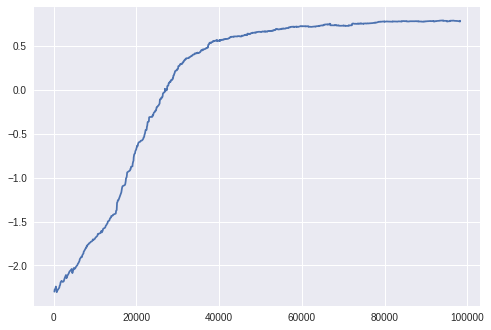

In [14]:
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=100))

# Enjoy model

In [11]:
import numpy as np 

observation = env.reset()
state = np.zeros((1, 2*128))
dones = np.zeros((1))

BeraterEnv.showStep = True
BeraterEnv.showDone = False

for t in range(1000):
    actions, _, state, _ = model.step(observation, S=state, M=dones)
    observation, reward, done, info = env.step(actions[0])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

Episode:    0   Step:    1  S --1-> B R= 0.07 totalR= 0.07 cost= 100 customerR=1000 optimum=13000
Episode:    0   Step:    2  B --3-> K R= 0.06 totalR= 0.13 cost= 200 customerR=1000 optimum=13000
Episode:    0   Step:    3  K --1-> H R= 0.05 totalR= 0.18 cost= 300 customerR=1000 optimum=13000
Episode:    0   Step:    4  H --0-> E R= 0.07 totalR= 0.25 cost= 100 customerR=1000 optimum=13000
Episode:    0   Step:    5  E --0-> A R= 0.07 totalR= 0.32 cost= 100 customerR=1000 optimum=13000
Episode:    0   Step:    6  A --3-> D R= 0.07 totalR= 0.39 cost= 100 customerR=1000 optimum=13000
Episode:    0   Step:    7  D --1-> F R= 0.07 totalR= 0.47 cost=  50 customerR=1000 optimum=13000
Episode:    0   Step:    8  F --2-> G R= 0.06 totalR= 0.53 cost= 200 customerR=1000 optimum=13000
Episode:    0   Step:    9  G --1-> O R= 0.05 totalR= 0.58 cost= 300 customerR=1000 optimum=13000
Episode:    0   Step:   10  O --0-> N R= 0.07 totalR= 0.65 cost= 100 customerR=1000 optimum=13000
Episode:    0   Step